In [2]:
import jax
import jax.numpy as jnp # type: ignore
import numpy as np # type: ignore

from jax import grad, jit, vmap, pmap # type: ignore
import matplotlib.pyplot as plt


In [3]:
simple_pytree = [
    [9, 5, None],
    [3, (2, 8)],
    {"p": 78},
    {"q": {"r": 5, "s": {"t": 100, "u": 200}}},
    4
]

for elem in simple_pytree:
    leaves = jax.tree_util.tree_leaves(elem)
    print(f"{elem} contains {len(leaves)} leaves ... {leaves}")

[9, 5, None] contains 2 leaves ... [9, 5]
[3, (2, 8)] contains 3 leaves ... [3, 2, 8]
{'p': 78} contains 1 leaves ... [78]
{'q': {'r': 5, 's': {'t': 100, 'u': 200}}} contains 3 leaves ... [5, 100, 200]
4 contains 1 leaves ... [4]


In [4]:
print(jax.tree_util.tree_map(lambda x: x**2, simple_pytree))

[[81, 25, None], [9, (4, 64)], {'p': 6084}, {'q': {'r': 25, 's': {'t': 10000, 'u': 40000}}}, 16]


In [5]:
# For the above, we can use multiple different pytrees but they must have the same structure in order to be operated together.

In [6]:
def init_mlp_params(layer_widths):
    params = []

    for n_in, n_out in zip(layer_widths[:-1], layer_widths[1:]):
        params.append(
            dict(weight=np.random.normal(size=(n_in, n_out)) * np.sqrt(2 / n_in),
                bias=np.ones(shape=(n_out,))
            )
        )
    
    return params

params = init_mlp_params([1, 128, 128, 1])
jax.tree_util.tree_map(lambda x: x.shape, params)

[{'bias': (128,), 'weight': (1, 128)},
 {'bias': (128,), 'weight': (128, 128)},
 {'bias': (1,), 'weight': (128, 1)}]

In [7]:
def forward(params, x):
    *hidden, last = params

    for layer in hidden:
        x  = jax.nn.relu(jnp.dot(x, layer["weight"]) + layer["bias"])

    return jnp.dot(x, last["weight"]) + last["bias"]

def loss_fn(params, x, y):
    return jnp.mean((forward(params, x) - y) ** 2)

lr = 0.0001

@jit
def update(params, x, y):

    grads = jax.grad(loss_fn)(params, x, y)

    return jax.tree.map(lambda p, g: p - lr * g, params, grads)

An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.


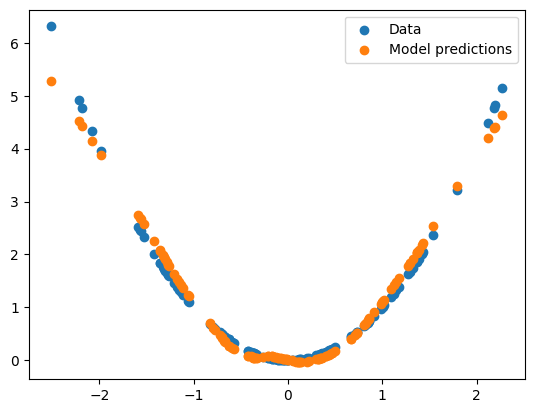

In [8]:
xs = np.random.normal(size=(128, 1))
ys = xs ** 2

num_epochs = 5000
for _ in range(num_epochs):
    params = update(params, xs, ys)

plt.scatter(xs, ys, label="Data")
plt.scatter(xs, forward(params, xs), label="Model predictions")
plt.legend()

In [11]:
class ExampleObject:
    def __init__(self, name, x, y, z):
        self.name = name
        self.x = x
        self.y = y
        self.z = z

custom_pytree = [ExampleObject("Jamie", 2, 1, 3), ExampleObject("McGowan", 1, 9, 6)]

leaves = jax.tree_util.tree_leaves(custom_pytree)
print(f"{custom_pytree} contains {len(leaves)} leaves ... {leaves}")

[<__main__.ExampleObject object at 0x7f9c50051cd0>, <__main__.ExampleObject object at 0x7f9c48717c80>] contains 2 leaves ... [<__main__.ExampleObject object at 0x7f9c50051cd0>, <__main__.ExampleObject object at 0x7f9c48717c80>]


In [ ]:
def flatten_ExampleObject(obj):
    flat_content = [obj.x, obj.y, obj.z]

    aux_data = obj.name

    return flat_content, aux_data

def unflatten_ExampleObject(flat_content, aux_data):
    return ExampleObject(aux_data, *flat_content)